In [19]:
# Projet 8 : Réalisez un dashboard et assurez une veille technique - Notebook de veille technique

Ce notebook présente la veille technique sur l'analyse de la faisabilité de classification d'imgaes.
Nous utilisons les données du projet 6 "Classifiez automatiquement les biens de consommation".
Dans ce projet, nous avions analysé la faisabilité de classifier les produits de consommation en extraiyant les features des images de ces produits via le modèle préentraîné VGG16. Par la suite, nous avons réduire les dimensions via une combinaison PCA et t-SNE et une projection en 2D avec analyse visuelle des différents clusters.
Il est donc question ici de montrer une nouvelle approche d'extraction des features plus récente via ViT modèle google
/
vit-base-patch16-224-in21k et faire un comparatif des deux approches.

In [20]:
! pip install torch

In [21]:
import pandas as pd
import os
import torch
from transformers import ViTModel, ViTImageProcessor
from PIL import Image

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [25]:
# Charger le fichier CSV contenant la listes des images ainsi que leurs labels
csv_path = '/content/drive/My Drive/P8/flipkart.csv'
df = pd.read_csv(csv_path, sep=',', index_col=[0], encoding='utf-8')
df

,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [26]:
# Chemin vers le dossier contenant tes images
image_folder = '/content/drive/My Drive/P8/Images'

In [27]:
# Initialiser ViT et le processeur d'images
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')


In [28]:
# S'assurer que le modèle utilise le GPU s'il est disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [29]:
import numpy as np

In [30]:
# Fonction pour extraire les features d'une image
def extract_features(image_path):
    # Charger l'image
    image = Image.open(image_path)
    inputs = image_processor(images=image, return_tensors="pt")

    # Envoyer l'entrée et le modèle sur le même appareil (CPU ou GPU)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Extraire les features
    with torch.no_grad():
        outputs = model(**inputs)

    # Obtenir le dernier état caché du modèle ViT
    last_hidden_states = outputs.last_hidden_state

    # Moyenne des features (global pooling)
    features = last_hidden_states.mean(dim=1).squeeze().cpu().numpy()
    return features

In [31]:
# Extraire les features pour chaque image et les ajouter au DataFrame
features_list = []
for index, row in df.iterrows():
    image_path = os.path.join(image_folder, row['image_path'])  # Concaténer le chemin de l'image
    features = extract_features(image_path)
    features_list.append(features)

# Convertir les features en un DataFrame
features_df = pd.DataFrame(features_list)

# Concaténer les features au DataFrame original
df_with_features = pd.concat([df, features_df], axis=1)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
df_with_features

,uniq_id,image_path,label_name,label,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,-0.151782,-0.151468,-0.111649,-0.100542,-0.095956,-0.033097,...,-0.111711,0.122290,0.064302,-0.317029,-0.229471,-0.109181,-0.079856,0.090174,-0.169382,0.197785
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,-0.111422,0.275146,-0.091587,0.282748,-0.062385,-0.202180,...,-0.283299,0.117427,-0.052772,0.062536,0.139276,0.087275,-0.033228,0.063497,-0.022677,-0.044075
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,-0.030365,0.074239,-0.065634,0.096911,-0.004830,-0.057935,...,-0.007512,0.106234,-0.221917,-0.048659,0.128593,-0.101945,0.020033,0.047527,0.005850,-0.041353
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4,-0.044524,0.031826,-0.098036,-0.066030,0.188642,-0.049035,...,-0.088858,0.034642,0.143425,-0.008346,-0.010117,-0.171103,-0.004044,-0.067704,0.246992,-0.168364
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4,-0.233772,-0.203876,-0.214859,-0.051071,0.014127,0.116186,...,-0.243573,0.065384,-0.008602,0.102079,0.031575,-0.223191,-0.215245,0.019388,0.125352,-0.244499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0,-0.016809,-0.128280,-0.257261,-0.170730,0.000512,0.098979,...,-0.570018,0.124617,-0.053929,0.045065,-0.146386,-0.133062,-0.049152,-0.005789,-0.205905,-0.019214
1046,fd6cbcc22efb6b761bd564c28928483c,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0,0.139451,0.037445,-0.140664,-0.030217,0.076962,0.038920,...,-0.500199,0.146731,0.180693,0.037483,-0.137788,-0.196576,-0.075946,0.146223,-0.287985,0.077112
1047,5912e037d12774bb73a2048f35a00009,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0,0.197369,-0.131306,-0.258323,-0.238667,-0.037978,0.140603,...,-0.255075,0.079225,0.189806,0.115565,0.038601,-0.059042,-0.033066,-0.156405,-0.051618,-0.189081
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0,0.143248,-0.039462,-0.280613,0.035725,-0.029096,-0.055795,...,-0.184029,0.112721,0.012284,0.079527,-0.094057,0.018533,-0.210789,0.080460,-0.294073,0.068153


In [32]:
# Faisabilité de classification des images

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

In [34]:
features = df_with_features.iloc[:, 4:].values
labels = df_with_features['label'].values

In [35]:
# Étape 1 : Réduction de la dimensionnalité avec PCA tout en conservant 99 % de la variance
pca = PCA(n_components=0.99, random_state=42)  # Conserve 99 % de la variance
features_pca = pca.fit_transform(features)
print("Dimensions dataset avant réduction PCA : ", features.shape)
print("Dimensions dataset après réduction PCA : ", features_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 531)


In [36]:
# Étape 2 : Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=20, learning_rate=400, n_iter=2000, init='random')
features_tsne = tsne.fit_transform(features_pca)

df_tsne = pd.DataFrame(features_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_with_features["label_name"]
print(df_tsne.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1050, 3)


In [37]:
# Analyse mesures : similarité entre catégories et clusters

In [38]:
## Création de clusters à partir du T-SNE

In [39]:
cls = KMeans(n_clusters=7, random_state=42)
cls.fit(features_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


In [40]:
## Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

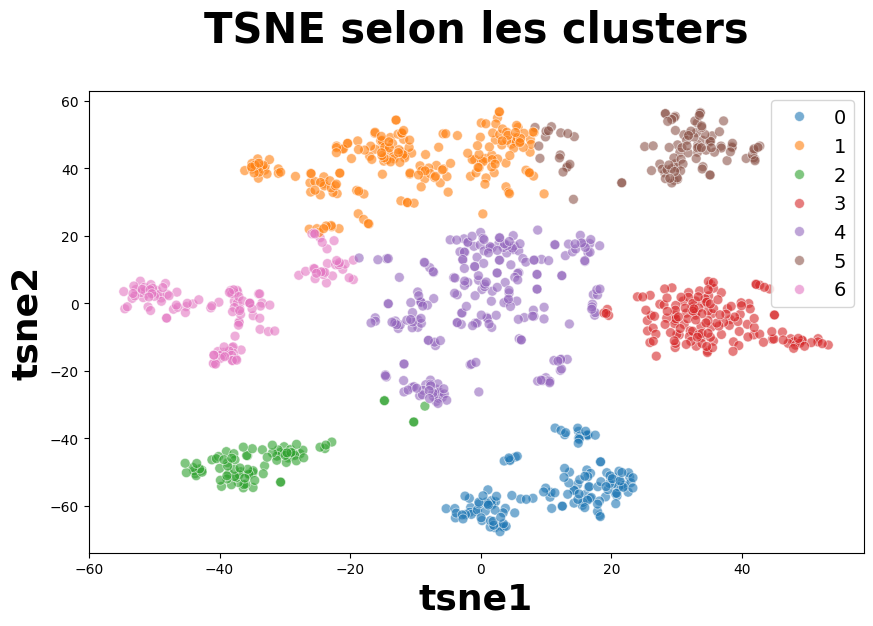

ARI :  0.567823916977064


In [41]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = df_with_features["label"]
print("ARI : ", adjusted_rand_score(labels, cls.labels_))